In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import (Trainer, TrainingParams, get_dis_loss_bhs,
                     get_dis_loss_ipm, get_dis_loss_wasserstein,
                     get_gen_loss_bhs, get_gen_loss_ipm,
                     get_gen_loss_wasserstein)
from utils import get_device, get_noise, init_weights, plot_tensor_images, plot_losses
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [3]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.0420382022857666 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


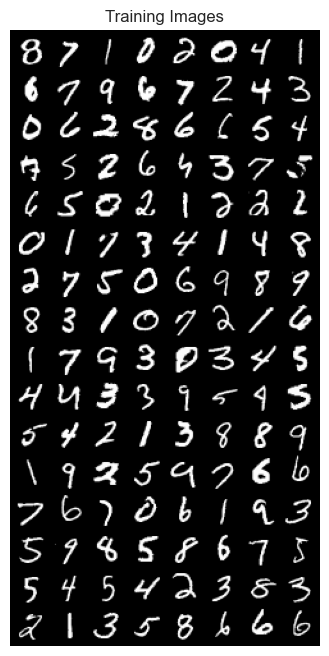

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [5]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [5]:
training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=1,
                                 num_dis_updates=5,
                                 num_gen_updates=1,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [88]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [89]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 16.399503	Loss_C : -3.314907	Loss_G : -3.833015	
Total_Time : 16.399503
Loss_C : -3.314907
Loss_G : -3.833015
Loss_C_Mean : -3.597823
Loss_G_Mean : -1.360363

----------------------------------------------



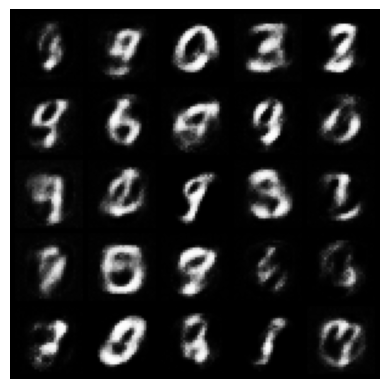

In [90]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25)

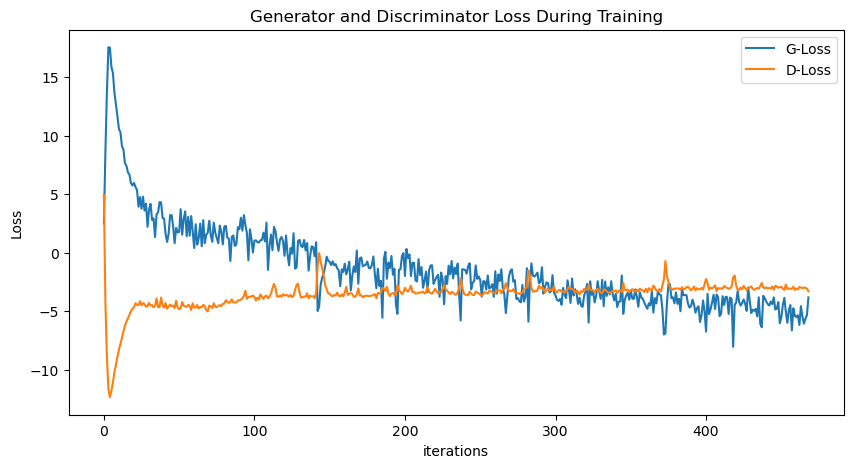

In [96]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

## BHS Gan

In [209]:
torch.manual_seed(1)
random.seed(1)

training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=8, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [210]:
# training loop
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/8 Total Steps:469
Total_Time : 14.219892
Loss_C : 0.031877
Loss_G : -0.093411
Loss_C_Mean : 0.029058
Loss_G_Mean : -0.174590

----------------------------------------------

Epoch 2 start training...
Epoch: 2/8 Total Steps:938
Total_Time : 13.885586
Loss_C : 0.010477
Loss_G : -0.048141
Loss_C_Mean : 0.015368
Loss_G_Mean : -0.069947

----------------------------------------------

Epoch 3 start training...
Epoch: 3/8 Total Steps:1407
Total_Time : 13.868572
Loss_C : 0.021638
Loss_G : -0.080530
Loss_C_Mean : 0.007411
Loss_G_Mean : -0.062637

----------------------------------------------

Epoch 4 start training...
Epoch: 4/8 Total Steps:1876
Total_Time : 13.817524
Loss_C : -0.001772
Loss_G : -0.049428
Loss_C_Mean : 0.008065
Loss_G_Mean : -0.059496

----------------------------------------------

Epoch 5 start training...
Epoch: 5/8 Total Steps:2345
Total_Time : 13.750097
Loss_C : -0.002339
Loss_G : -0.034992
Loss_C_Mean : 0.010363
Loss_G_Mean : -0.055470

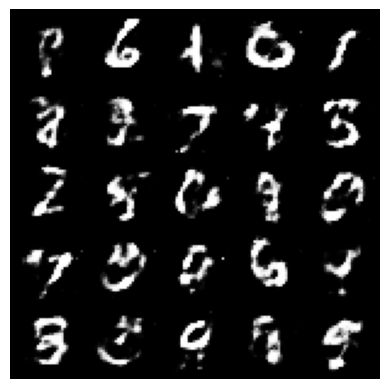

In [211]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=25)

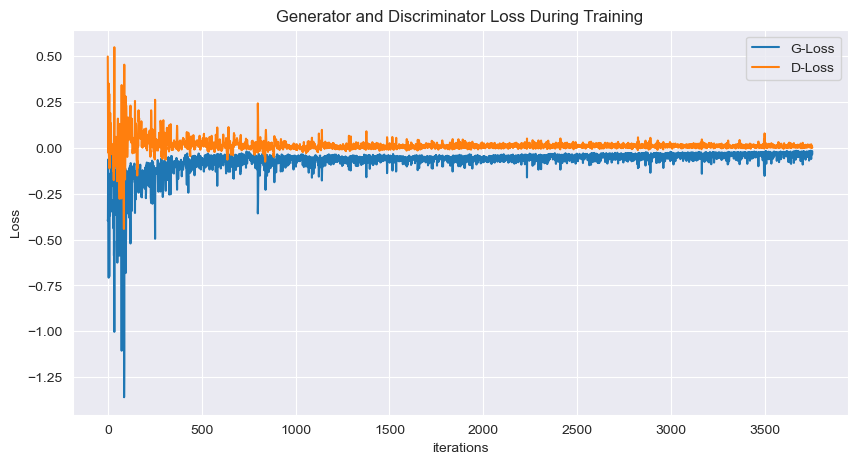

In [213]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## IPM BHS GAN

In [17]:
training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=5, num_gen_updates=1, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [18]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 156.963749	Loss_C : -26.251930	Loss_G : -47.110443		
Total_Time : 156.963749
Loss_C : -26.251930
Loss_G : -47.110443
Loss_C_Mean : -128.501740
Loss_G_Mean : 143.992394

----------------------------------------------



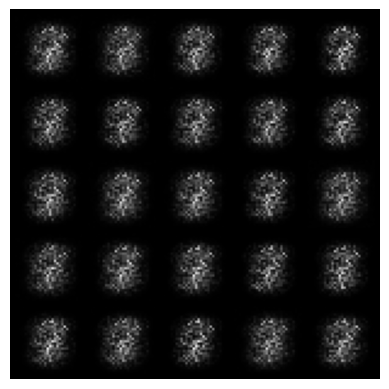

In [19]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

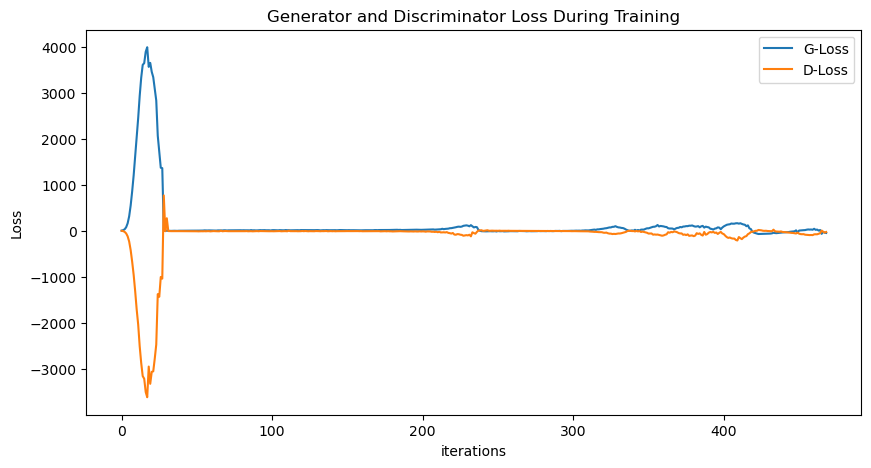

In [20]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)